In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import *
import cv2
import numpy as np
import random
import os
import pandas as pd
import warnings
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Concatenate, Activation, Multiply, Reshape,
    GlobalAveragePooling2D, Dense, AveragePooling2D, Lambda, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers


C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
import tensorflow as tf

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\train",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\val",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\test",
    target_size=(224, 224),
    batch_size=16,
    shuffle=False  
)

print("Train classes:", train_generator.class_indices)
print("Validation classes:", val_generator.class_indices)
print("Test classes:", test_generator.class_indices)


Found 6660 images belonging to 4 classes.
Found 1918 images belonging to 4 classes.
Found 1293 images belonging to 4 classes.
Train classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Validation classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Test classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}


In [ ]:
train_dir =r"D:\Akshaya\Resampled prostate images with reduced images - Copy\train"
test_dir =  r"D:\Akshaya\Resampled prostate images with reduced images - Copy\Valid"
valid_dir = r"D:\Akshaya\Resampled prostate images with reduced images - Copy\test"
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size= 4
img_height =256
img_width =256
no_of_classes = 4
classes_name=['Class 0','Class 1','Class 2','Class 3']
input_shape = (img_height, img_width, 3)
random_seed =np.random.seed(52)

datagen = ImageDataGenerator( rescale=1. / 255,
                             featurewise_center=True,
                             horizontal_flip = False,
                             vertical_flip = False,
                             #validation_split = 0.1,
                             featurewise_std_normalization=True)

train_generator = datagen.flow_from_directory(train_dir,
                                               target_size=(img_height, img_width),
                                               batch_size=batch_size,
                                               shuffle = True,
                                               class_mode='categorical')

validation_generator = datagen.flow_from_directory(valid_dir,
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size,
                                                   shuffle = True,
                                                   class_mode='categorical')

Found 11684 images belonging to 4 classes.
Found 2854 images belonging to 4 classes.


In [6]:
def conv_block(filter,x):
  b0=Conv2D(filter,(3,3),padding='same')(x)
  b1=BatchNormalization()(b0)
  b2=Activation('relu')(b1)
  return b2
def residual_block(filter,x):
  w,h,c = x.shape[1],x.shape[2],x.shape[3]
  r0=AveragePooling2D(pool_size=(w,h))(x)
  r0=Conv2D(filter,(1,1),activation='sigmoid',padding='same')(r0)
  r1=Multiply()([x,r0])
  return r1
def context_guided(x,y):
    x1 = tf.math.reduce_mean(x, axis=3, name=None,keepdims=True)
    x2 = tf.math.reduce_max(x, axis=3, name=None,keepdims=True)
    x12 = Concatenate()([x1,x2])
    x12 = Conv2D(1,1)(x12)
    x12 = Activation('sigmoid')(x12)
    xy12 = Multiply()([y,x12])
    xy = Add()([xy12,x])
    return xy
def scr_block(x,y,filters,gr):
  y1 = y
  _,width,height,channel=list(x.shape)
  get_channel=channel//gr
  x=Reshape([width,height,get_channel,gr])(x)
  x=Permute([1,2,4,3])(x)
   
  _,width,height,channel=list(y.shape)
  get_channel=channel//gr
  y=Reshape([width,height,get_channel,gr])(y)
  y=Permute([1,2,4,3])(y)

  for i in range(gr):
        if i != 0 and i!=(gr-1):
            concat1 = y[:,:,:,0]
            for j in range(1,i):
                concat1 = Concatenate()([concat1,y[:,:,:,j]])
            concat1 = Concatenate()([concat1,(x[:,:,:,i]+y[:,:,:,i])])
            for j in range(i+1,gr):
                concat1 = Concatenate()([concat1,x[:,:,:,j]])
        elif i == (gr-1):
            concat1 = y[:,:,:,0]
            for j in range(1,i):
                concat1 = Concatenate()([concat1,y[:,:,:,j]])
            concat1 = Concatenate()([concat1,(x[:,:,:,i]+y[:,:,:,i])])
        else:
            concat1 = x[:,:,:,0]+y[:,:,:,0]
            for j in range(1,gr):
                concat1 = Concatenate()([concat1,y[:,:,:,j]])  
        res_x = residual_block(channel,concat1)
        if i==0:
            x_out = res_x
        else:
            x_out = Concatenate()([x_out,res_x])
  x_out = Conv2D(channel,1,padding='same',activation='relu')(x_out)
  x_out = context_guided(x_out,y1)
  x_out = Conv2D(channel,1,padding='same')(x_out)
  return x_out

def resnet_block(block_input,filters,gr):
  conv1=conv_block(filters,block_input)
  conv2=scr_block(block_input,conv1,filters,gr)
  sum=Add()([conv2,block_input])
  res_out=Activation('relu')(sum)
  return res_out

def ProsGradNet():
  input = Input(shape=(256,256,3))
  conv1 = conv_block(16,input)
  scr1 = resnet_block(conv1,16,2)
  scr2 = resnet_block(conv1,16,4)
  scr3 = resnet_block(conv1,16,8)
  Add1 = Add()([scr1,scr2,scr3])
  pool1 = AveragePooling2D((2,2),(2,2))(Add1)
  conv2 = conv_block(32,pool1)
  scr4 = resnet_block(conv2,32,2)
  scr5 = resnet_block(conv2,32,4)
  scr6 = resnet_block(conv2,32,8)
  Add2 = Add()([scr4,scr5,scr6])
  pool2 = MaxPooling2D((2,2),(2,2))(Add2)
  conv3 = conv_block(64,pool2)
  scr7 = resnet_block(conv3,64,2)
  scr8 = resnet_block(conv3,64,4)
  scr9 = resnet_block(conv3,64,8)
  Add3 = Add()([scr7,scr8,scr9])
  pool3 = GlobalAveragePooling2D()(Add3)
  output = Dense(4, activation='softmax')(pool3)
  model = Model(inputs = input, outputs = output)
  return model
model = ProsGradNet()
model.compile(optimizer = 'Adam' , loss = 'categorical_crossentropy' , metrics = ["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc' , mode='max' ,
                                                  factor = 0.5 , patience = 8 , verbose=1 , cooldown = 1,
                                                 min_delta = 0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=30, verbose=1,
                                              mode = 'max', restore_best_weights = True)
check_path = r'ProstgradeNet.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(check_path, monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')


history_1 = model.fit(train_generator , validation_data = validation_generator ,
                                  steps_per_epoch= len(train_generator) ,
                                  validation_steps = len(validation_generator)
                                  ,epochs = 65,callbacks = [reduce_lr, early_stop, checkpoint] )

C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/65
2921/2921 [==============================] - 696s 232ms/step - loss: 0.7833 - acc: 0.6553 - val_loss: 0.6788 - val_acc: 0.7186

Epoch 00001: val_acc improved from -inf to 0.71864, saving model to ProstgradeNet.h5
Epoch 2/65
2921/2921 [==============================] - 675s 231ms/step - loss: 0.5813 - acc: 0.7385 - val_loss: 0.5446 - val_acc: 0.7547

Epoch 00002: val_acc improved from 0.71864 to 0.75473, saving model to ProstgradeNet.h5
Epoch 3/65
2921/2921 [==============================] - 674s 231ms/step - loss: 0.4963 - acc: 0.7723 - val_loss: 1.6879 - val_acc: 0.4275

Epoch 00003: val_acc did not improve from 0.75473
Epoch 4/65
2921/2921 [==============================] - 675s 231ms/step - loss: 0.4531 - acc: 0.7975 - val_loss: 0.7646 - val_acc: 0.7158

Epoch 00004: val_acc did not improve from 0.75473
Epoch 5/65
2921/2921 [==============================] - 675s 231ms/step - loss: 0.4308 - acc: 0.8077 - val_loss: 1.0430 - val_acc: 0.5564

Epoch 00005: val_acc did not imp

In [8]:
np.save('ProsGradeNet.npy',history_1.history)

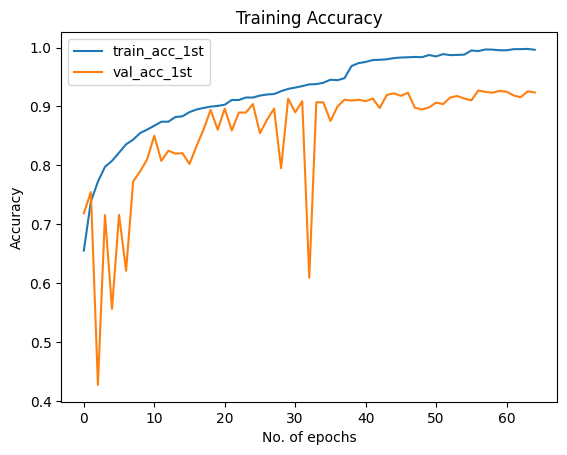

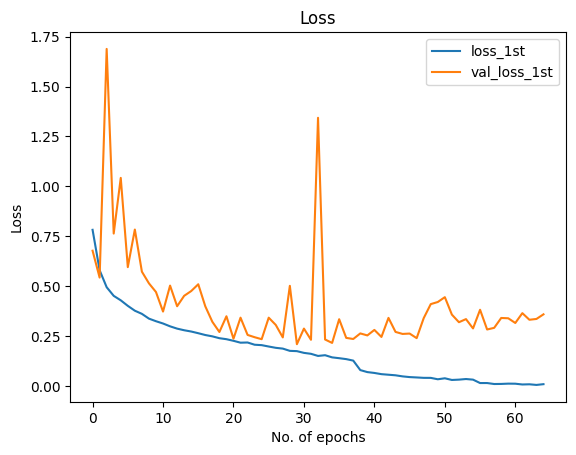

In [9]:
a=np.load(r'ProsGradeNet.npy',allow_pickle='TRUE').item()
plt.plot(a['acc'] , label = 'train_acc_1st')
plt.plot(a['val_acc'] , label = 'val_acc_1st')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.show()
plt.plot(a['loss'] , label = 'loss_1st')
plt.plot(a['val_loss'] , label = 'val_loss_1st')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

In [ ]:
test_d = ImageDataGenerator(rescale=1. / 255)
test = test_d.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=1,
    shuffle = False,
    class_mode='categorical')

import numpy as np
test_step = test.n//test.batch_size
test.reset()
pred = model.predict_generator(test , steps = test_step , verbose = 1)
pred_class_indices = np.argmax(pred,axis=1)

print(pred_class_indices)

from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score,jaccard_score,classification_report
from sklearn.metrics import precision_score,recall_score,jaccard_score
classes = [0,1,2,3]


for cl in classes:

    print("class: ",cl)

    a1 = np.uint8(test.labels == cl)
    a2 = np.uint8(pred_class_indices == cl)

    print('Accuracy {}'.format(accuracy_score(y_true=a1, y_pred=a2)))
    print('F1 {}'.format(f1_score(y_true=a1, y_pred=a2)))
    print('precision {}'.format(precision_score(y_true=a1, y_pred=a2)))
    print('recall {}'.format(recall_score(y_true=a1, y_pred=a2)))

    print('jaccard {}'.format(jaccard_score(y_true=a1, y_pred=a2)))
    print("_______________________________")


print('Accuracy {}'.format(accuracy_score(y_true=test.labels, y_pred=pred_class_indices)))
print('F1 {}'.format(f1_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('precision {}'.format(precision_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('recall {}'.format(recall_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('confusion_matrix\n {}'.format(confusion_matrix(y_true=test.labels, y_pred=pred_class_indices)))
print('classification_report\n {}'.format(classification_report(y_true=test.labels, y_pred=pred_class_indices)))
print('\n\n')

Found 2939 images belonging to 4 classes.
   8/2939 [..............................] - ETA: 51s

C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


2939/2939 [==============================] - 62s 21ms/step
[0 0 0 ... 3 3 3]
class:  0
Accuracy 0.9407961891799932
F1 0.8916562889165628
precision 0.8883374689826302
recall 0.895
jaccard 0.8044943820224719
_______________________________
class:  1
Accuracy 0.9193603266417149
F1 0.8408327736736065
precision 0.8226018396846255
recall 0.8598901098901099
jaccard 0.7253765932792584
_______________________________
class:  2
Accuracy 0.9700578428036747
F1 0.9369627507163324
precision 0.9646017699115044
recall 0.9108635097493036
jaccard 0.8814016172506739
_______________________________
class:  3
Accuracy 0.9996597482136781
F1 0.9992790194664743
precision 0.9985590778097982
recall 1.0
jaccard 0.9985590778097982
_______________________________
Accuracy 0.9149370534195305
F1 0.917182708193244
precision 0.9185250390971397
recall 0.9164384049098534
jaccard 0.8524579175905507
confusion_matrix
 [[716  78   5   1]
 [ 83 626  19   0]
 [  7  57 654   0]
 [  0   0   0 693]]
classification_report
       